# Notebook to extract annual median NDVI for Turkey

In [3]:
from eo_processing.utils import bbox_area, init_connection, location_visu
from eo_processing.openeo.preprocessing import ts_datacube_extraction 
from eo_processing.openeo.processing import generate_master_feature_cube, generate_S2_indices
from eo_processing.config import get_job_options, get_collection_options, get_advanced_options, get_standard_processing_options
import os
import json
import xarray
import rasterio
from matplotlib import pyplot
from rasterio.plot import show, show_hist

Authenticated using refresh token.


## connect to openEO processing backend

In [4]:
backend = 'cdse' # also possible: terrascope, development, creodias, sentinelhub
# establish the connection to the selected backend
connection = init_connection(backend)

Authenticated using refresh token.


### init the job, collection and processing options
Lori wants the annual median NDVI for 2017 to 2023 -> we use one of the convient functions and deactivate the append to only get the NDVI data

In [7]:
job_options = get_job_options(provider=backend)
collection_options = get_collection_options(provider=backend)
processing_options = get_advanced_options(provider=backend, S2_bands=['B04', 'B08'], optical_vi_list=['NDVI'], append=False, ts_interval='year')

In [9]:
# just print for an overview
print(f'job_options: {job_options}')
print(f'collection_options: {collection_options}')
print(f'processing_options: {processing_options}')

job_options: {'driver-memory': '8G', 'driver-memoryOverhead': '5G', 'driver-cores': '1', 'executor-memory': '1500m', 'executor-memoryOverhead': '2500m', 'executor-cores': '1', 'max-executors': '25', 'soft-errors': 'true', 'executor-request-cores': '800m', 'executor-threads-jvm': '7', 'logging-threshold': 'info'}
collection_options: {'S2_collection': 'SENTINEL2_L2A', 'S1_collection': 'SENTINEL1_GRD'}
processing_options: {'provider': 'cdse', 's1_orbitdirection': 'DESCENDING', 'target_crs': 3035, 'resolution': 10.0, 'time_interpolation': False, 'ts_interval': 'year', 'SLC_masking_algo': 'mask_scl_dilation', 'S2_bands': ['B04', 'B08'], 'optical_vi_list': ['NDVI'], 'radar_vi_list': ['VHVVD', 'VHVVR', 'RVI'], 'S2_scaling': [0, 10000, 0, 1.0], 'S1_db_rescale': True, 'append': False}


### specify space & time context

In [11]:
# the time context is given by start and end date
start = '2017-01-01'
end = '2024-01-01'   # the end is always exclusive

# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Slovakia Devin_Lake (wetlands)
AOI = {'east': 6605200, 'south': 2397500, 'west': 6603500, 'north': 2399500, 'crs': 'EPSG:3035'}

area of AOI in km2: 3.4


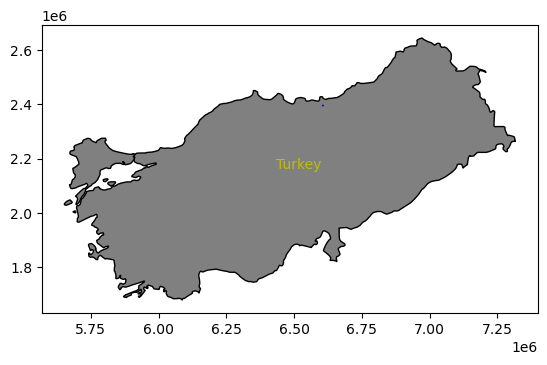

In [13]:
# get area and location print
bbox_area(AOI)
location_visu(AOI, zoom=True, region='EU', label=True)

### get the data from openEO
Note: in these examples we directly extract the data for the given AOI --> maximum area for such requests should not be bigger than 400km2.
      If you want to run bigger areas then you need area spliting by a tiling grid -> see additional example notebooks.

In [17]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 12
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\eo_processing')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [19]:
# define the openEO pipeline to use
data_cube = generate_S2_indices(connection,
                                   AOI,
                                   start,
                                   end,
                                   **collection_options,
                                   **processing_options)

# run the job on openEO as batch job
try:
    job = data_cube.execute_batch(title=f'NDVI datacube extraction AOI - run {str(test_num)}',
                                  description='generation of NDVI times series datacube of EO data',
                                  out_format='NetCDF',
                                  job_options=job_options)
            
    # Get the results and save to output file
    results = job.get_results()

    outputfile_vi = os.path.join(out_root, f'NDVI_timeseries_Turkey_v{str(test_num)}.nc')
    results.download_file(outputfile_vi)
    # get metadata and job info
    with open(outputfile_vi.replace('.nc','.json'), "w") as outfile:
        json.dump(results.get_metadata(),outfile)
    with open(outputfile_vi.replace('.nc','-job.json'), "w") as outfile:
        json.dump(job.describe_job(),outfile)

except Exception as e:
    print(e)

0:00:00 Job 'j-2410073f71e348729fcf74e715bfd7f2': send 'start'
0:00:22 Job 'j-2410073f71e348729fcf74e715bfd7f2': created (progress 0%)
0:00:28 Job 'j-2410073f71e348729fcf74e715bfd7f2': created (progress 0%)
0:00:34 Job 'j-2410073f71e348729fcf74e715bfd7f2': queued (progress 0%)
0:00:42 Job 'j-2410073f71e348729fcf74e715bfd7f2': queued (progress 0%)
0:00:52 Job 'j-2410073f71e348729fcf74e715bfd7f2': queued (progress 0%)
0:01:04 Job 'j-2410073f71e348729fcf74e715bfd7f2': queued (progress 0%)
0:01:20 Job 'j-2410073f71e348729fcf74e715bfd7f2': queued (progress 0%)
0:01:39 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)
0:02:08 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)
0:02:40 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)
0:03:18 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)
0:04:04 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)
0:05:03 Job 'j-2410073f71e348729fcf74e715bfd7f2': running (progress N/A)


### visualize the results

In [21]:
# load netCDF
ts2 = xarray.load_dataset(outputfile_vi)
ts2

<xarray.Dataset> Size: 955kB
Dimensions:  (t: 7, x: 170, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 56B 2017-01-01 2018-01-01 ... 2023-01-01
  * x        (x) float64 1kB 6.604e+06 6.604e+06 ... 6.605e+06 6.605e+06
  * y        (y) float64 2kB 2.399e+06 2.399e+06 ... 2.398e+06 2.398e+06
Data variables:
    crs      |S1 1B b''
    NDVI     (t, y, x) float32 952kB 0.7874 0.7812 0.7608 ... 0.7876 0.7837
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.40.1a1
    description:  
    title:

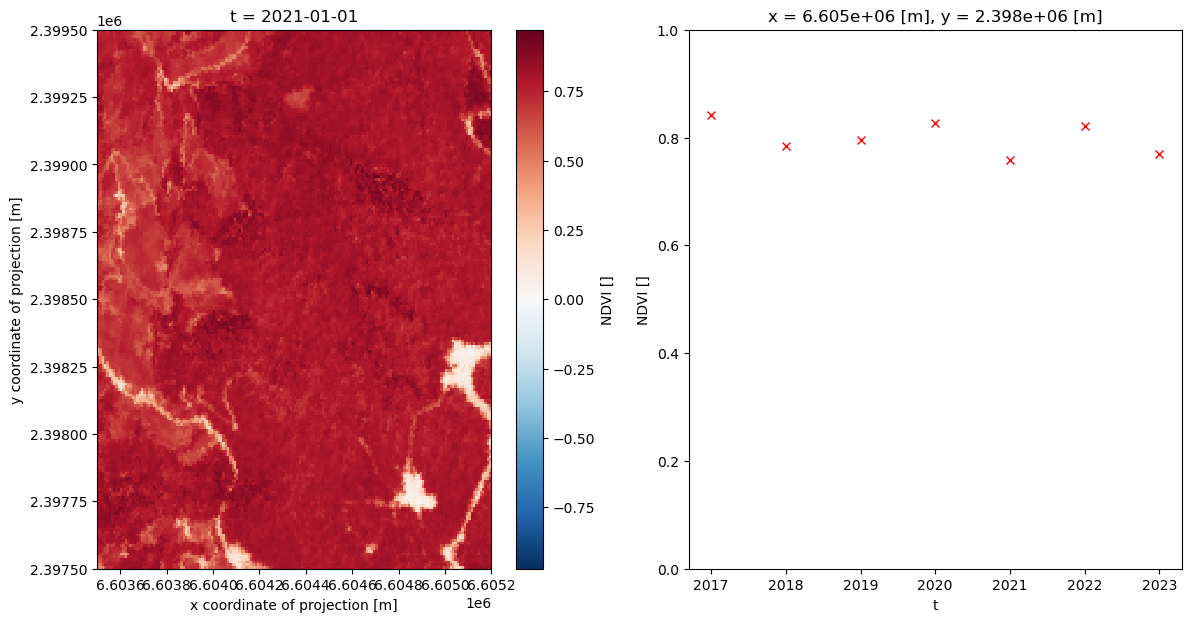

In [28]:
fig, (axNDVI, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
ts2.NDVI.sel(t = "2021-01-01").plot(ax=axNDVI)
ts2.NDVI[:,100,135].plot(ax=axhist, ylim=(0,1), marker='x', color='r', linestyle='')
pyplot.show()